## **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

## **Loading Food101 Data**

In [ ]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteE0YL4Y/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteE0YL4Y/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds, valid_ds = ds["train"], ds["validation"]

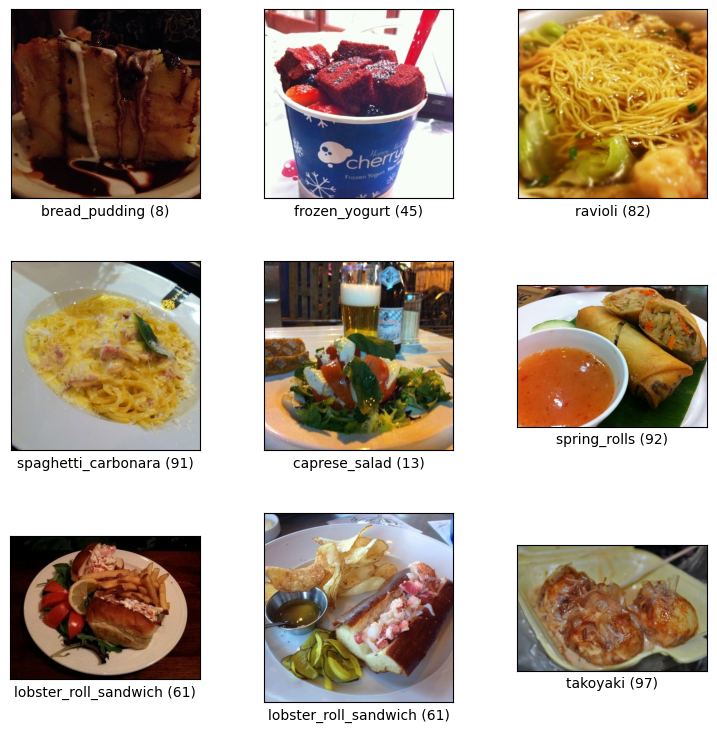

In [ ]:
fig = tfds.show_examples(train_ds, ds_info)

## **Resizing The Training and Validation Data Images**

In [ ]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS= 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype = tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype = tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)

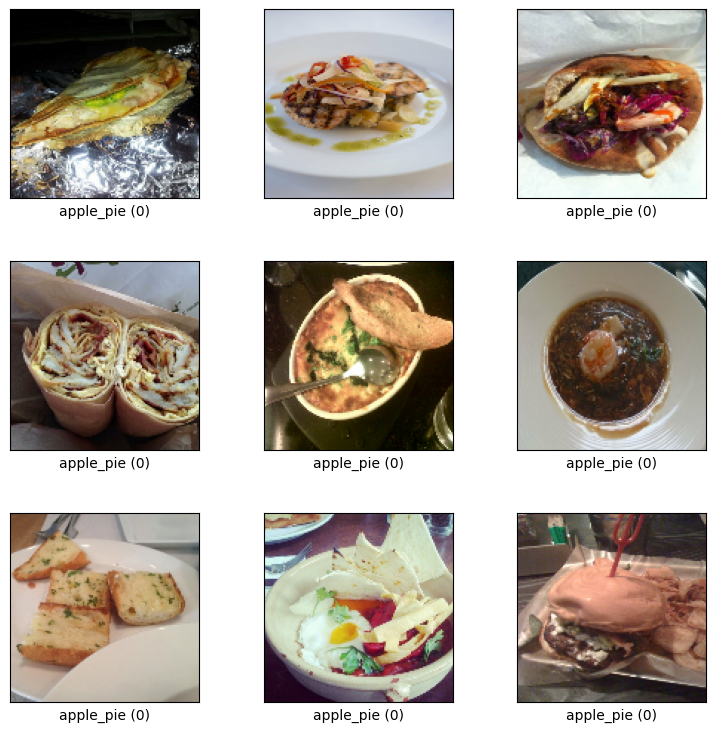

In [ ]:
fig = tfds.show_examples(train_ds, ds_info)

In [ ]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda image, label: label == 0)

In [ ]:
valid_hotdogs = valid_ds.filter(lambda image, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda image, label: label == 0)

In [ ]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
for image_batch, label_batch in  train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[ 20   9  10]
   [ 13   5   8]
   [  6   5   7]
   ...
   [ 12   3   5]
   [ 24  14  20]
   [ 35  20  27]]

  [[ 16   9   9]
   [ 14   9  10]
   [  8   5   7]
   ...
   [ 13   5   7]
   [ 23  13  18]
   [ 32  19  23]]

  [[ 16   8   9]
   [ 13   8  10]
   [  9   5   8]
   ...
   [ 25  19  20]
   [ 16   8  10]
   [ 32  21  20]]

  ...

  [[ 18   1   3]
   [ 32  14  14]
   [ 49  25  20]
   ...
   [108  73  52]
   [ 58  21  11]
   [ 49  12   7]]

  [[ 12   4   7]
   [ 11   4   7]
   [ 17   4   5]
   ...
   [ 47  14   5]
   [ 47  12  10]
   [ 47  12  13]]

  [[ 15   4   9]
   [ 10   2  10]
   [ 11   4   8]
   ...
   [ 40   9  10]
   [ 41  10  11]
   [ 40   9   9]]]


 [[[ 48   2   7]
   [ 53   3  10]
   [ 53   3  10]
   ...
   [  5   3   8]
   [  7   4   9]
   [ 15  11  12]]

  [[ 55   4   9]
   [ 56   2   8]
   [ 55   2   8]
   ...
   [  5   5   6]
   [  8   6   7]
   [ 15  14   9]]

  [[ 53   2   6]
   [ 58   4   9]
   [ 60   7  12]
   ...
   [  4   5   7]
   [  6   6   5]


## **Neural Net Implementation**

### **Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
for i,_ in ds["train"].take(1):
  image = i

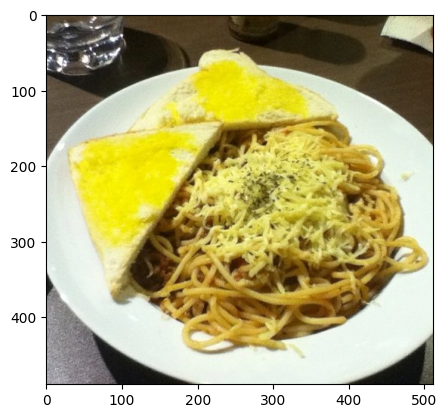

In [ ]:
plt.imshow(image)

In [ ]:
image  = tf.cast(tf.expand_dims(image, 0), tf.float32)
image /= 255.0

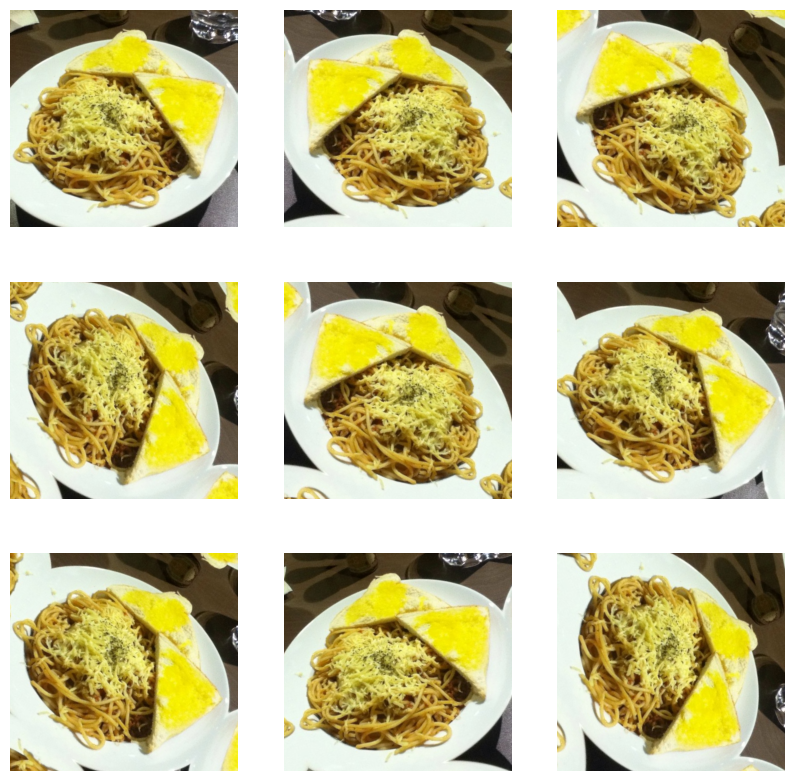

In [ ]:
plt.figure(figsize = (10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

### **Model Training**

In [ ]:
from keras.api._v2.keras import activations
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(64, (3, 3), activation = "relu", input_shape = [MAX_SIDE_LEN, MAX_SIDE_LEN, 3]))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [ ]:
lr = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(lr),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [ ]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = epochs,
    verbose = 1
)

Epoch 1/50
284/284 [==============================] - 900s 3s/step - loss: 1.4269 - accuracy: 0.5045 - val_loss: 1.1673 - val_accuracy: 0.4856
Epoch 2/50
284/284 [==============================] - 286s 1s/step - loss: 1.0195 - accuracy: 0.5201 - val_loss: 0.9101 - val_accuracy: 0.4870
Epoch 3/50
284/284 [==============================] - 285s 1s/step - loss: 0.8472 - accuracy: 0.5362 - val_loss: 0.8055 - val_accuracy: 0.4883
Epoch 4/50
284/284 [==============================] - 300s 1s/step - loss: 0.7770 - accuracy: 0.5413 - val_loss: 0.7597 - val_accuracy: 0.4890
Epoch 5/50
284/284 [==============================] - 282s 994ms/step - loss: 0.7416 - accuracy: 0.5459 - val_loss: 0.7285 - val_accuracy: 0.5027
Epoch 6/50
284/284 [==============================] - 283s 996ms/step - loss: 0.7208 - accuracy: 0.5541 - val_loss: 0.7098 - val_accuracy: 0.4911
Epoch 7/50
284/284 [==============================] - 286s 1s/step - loss: 0.7035 - accuracy: 0.5541 - val_loss: 0.6825 - val_accuracy: 

### **Testing the Data**

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

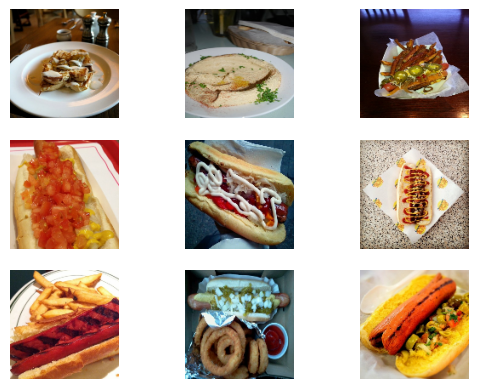

In [ ]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [ ]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>

### **Saving the Model**

In [ ]:
import pickle
filename = "Hotdog_or_not_model.sav"
pickle.dump(model, open(filename, 'wb'))